In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import meshio

import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import re
import os

In [2]:
input_file = 'test.geo'
output_file = 'test.msh'

In [3]:
def generate_quad2d_mesh(input_file, output_file, lc=50):
    gmsh.initialize()
    gmsh.open(input_file)

    # Fijar tamaño de elementos
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", lc)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", lc)

    # Recombinación: convierte triángulos en cuadriláteros
    gmsh.option.setNumber("Mesh.RecombineAll", 1)
    
    # Sincronizar geometría y generar malla 2D
    gmsh.model.geo.synchronize()
    gmsh.model.mesh.generate(2)

    # Guardar archivo de salida
    gmsh.write(output_file)
    gmsh.finalize()

generate_quad2d_mesh(input_file, output_file)

Info    : Reading 'test.geo'...
Info    : Done reading 'test.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 60%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000186583s, CPU 0.000218s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Blossom: 107 internal 44 closed
Info    : Blossom recombination completed (Wall 0.000943541s, CPU 0.000936s): 43 quads, 0 triangles, 0 invalid quads, 0 quads with Q < 0.1, avg Q = 0.857335, min Q = 0.522296
Info    : Done meshing 2D (Wall 0.00426246s, CPU 0.004246s)
Info    : 66 nodes 91 elements
Info    : Writing 'test.msh'...
Info    : Done writing 'test.msh'


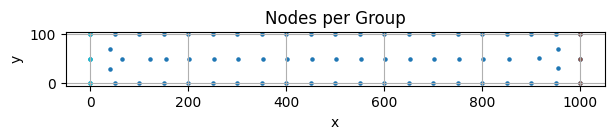

In [4]:
import meshio
from nodes import Node

def make_nodes_groups(output_file, title):
    mesh = meshio.read(output_file)
    
    # Traducimos los tags físicos a nombres
    tag_to_name = {v[0]: k for k, v in mesh.field_data.items()}
    grupos = {}

    # Elementos tipo "quad" → para el dominio estructural
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "quad":
            continue
        for quad, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, f"{tag}")
            if nombre not in grupos:
                grupos[nombre] = []
            for node_id in quad:
                x, y = mesh.points[node_id][:2]
                grupos[nombre].append(Node(node_id + 1, [x, y]))

    # Elementos tipo "line" → condiciones de borde
    for cell_block, phys_tags in zip(mesh.cells, mesh.cell_data["gmsh:physical"]):
        if cell_block.type != "line":
            continue
        for line, tag in zip(cell_block.data, phys_tags):
            nombre = tag_to_name.get(tag, f"{tag}")
            if nombre not in grupos:
                grupos[nombre] = []
            for node_id in line:
                x, y = mesh.points[node_id][:2]
                restrain = [0, 0]
                if nombre in ["Restr XY"]:
                    restrain = [1, 1]
                grupos[nombre].append(Node(node_id + 1, [x, y], restrain=restrain))

    # Eliminar nodos duplicados por grupo (según id)
    for nombre in grupos:
        nodos_unicos = {}
        for nodo in grupos[nombre]:
            nodos_unicos[nodo.index] = nodo
        grupos[nombre] = list(nodos_unicos.values())

    # Visualización opcional
    Node.plot_nodes_por_grupo(grupos, title, show_ids=False, save=False)

    return grupos, mesh

grupos, mesh = make_nodes_groups(output_file, "test")

In [5]:
from material import Material

class Membrane:
    def __init__(self, thickness, material):
        self.thickness = thickness
        self.material = material

def make_sections(grupos):
    thickness_dict = {"1": 100}
    sections = {}

    for group in thickness_dict:
        material = Material(E=200e3, nu=0.36, gamma=7800e-9)
        sections[group] = Membrane(thickness_dict[group], material)

    nodes_dict = {}
    for group in grupos:
        for node in grupos[group]:
            nodes_dict[node.index] = node

    return sections, nodes_dict

sections, nodes_dict = make_sections(grupos)


In [6]:
#bien, ahora creo los elementos

from Quad2D import Quad2D

def make_quad2d_elements(mesh, sections, nodes_dict):
    quads = mesh.cells_dict.get('quad', [])
    tags = mesh.cell_data_dict["gmsh:physical"].get("quad", [])
    elements = []
    used_nodes = set()
    nodos_faltantes = []

    for i in range(len(tags)):
        section_tag = str(tags[i])
        if section_tag not in sections:
            print(f"⚠️ Tag físico {section_tag} no tiene sección asociada. Elemento {i+1} omitido.")
            continue

        section = sections[section_tag]
        node_ids = quads[i]

        try:
            nodos = [nodes_dict[node_id + 1] for node_id in node_ids]
        except KeyError as e:
            nodos_faltantes.append(node_ids)
            print(f"❌ Nodo no encontrado en nodes_dict: {e}")
            continue

        for nodo in nodos:
            used_nodes.add(nodo)

        #print(nodos)

        element = Quad2D(i + 1, nodos, section)
        elements.append(element)

    if nodos_faltantes:
        print(f"❌ Se omitieron {len(nodos_faltantes)} elementos por nodos faltantes.")
    
    return elements, list(used_nodes)


elements, used_nodes = make_quad2d_elements(mesh, sections, nodes_dict)

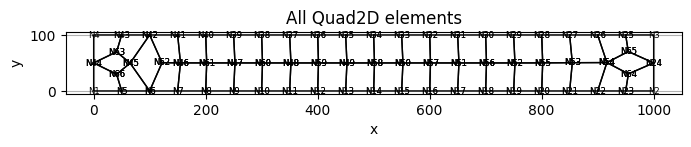

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_all_elements(elements, title, show_ids=True):
    all_x = []
    all_y = []

    # Recopilar coordenadas de todos los nodos
    for elem in elements:
        coords = elem.xy  # accede directamente a las coordenadas
        coords = np.vstack([coords, coords[0]])  # cerrar el polígono
        all_x.extend(coords[:, 0])
        all_y.extend(coords[:, 1])

    # Márgenes y límites
    x_min, x_max = min(all_x), max(all_x)
    y_min, y_max = min(all_y), max(all_y)
    x_margin = (x_max - x_min) * 0.05
    y_margin = (y_max - y_min) * 0.05

    x_range = (x_max - x_min) + 2 * x_margin
    y_range = (y_max - y_min) + 2 * y_margin

    fixed_width = 8
    aspect_ratio = y_range / x_range
    height = fixed_width * aspect_ratio

    fig, ax = plt.subplots(figsize=(fixed_width, height))

    for elem in elements:
        coords = elem.xy
        coords = np.vstack([coords, coords[0]])  # cerrar el polígono

        ax.plot(coords[:, 0], coords[:, 1], 'k-', linewidth=1)

        if show_ids:
            for nodo, (x, y) in zip(elem.node_list, coords[:-1]):
                ax.text(x, y, f'N{nodo.index}', color='black', fontsize=6, ha='center', va='center')

    ax.set_xlim(x_min - x_margin, x_max + x_margin)
    ax.set_ylim(y_min - y_margin, y_max + y_margin)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("All Quad2D elements")
    ax.grid(True)

    plt.show()

plot_all_elements(elements, "All Quad2D elements", show_ids=True)

In [8]:
from solve import Solve

estructure = Solve(used_nodes, elements)



In [9]:
def apply_distributed_force(grupo_nodos, fuerza_total_y, estructura):
    """
    Aplica una fuerza distribuida vertical (por ejemplo, peso) sobre una línea formada por nodos.
    La fuerza se reparte proporcionalmente a la longitud de los tramos y se descompone en x e y.
    """

    nodos = grupo_nodos
    n = len(nodos)
    if n < 2:
        print("Se requieren al menos dos nodos para aplicar fuerza distribuida.")
        return

    # Paso 1: calcular longitud total
    longitudes = []
    total_length = 0
    for i in range(n - 1):
        dx = nodos[i+1].coord[0] - nodos[i].coord[0]
        dy = nodos[i+1].coord[1] - nodos[i].coord[1]
        L = np.sqrt(dx**2 + dy**2)
        longitudes.append(L)
        total_length += L

    q_lineal = fuerza_total_y / total_length  # fuerza por metro

    # Paso 2: inicializar diccionario de fuerzas
    nodal_forces = {node.index: np.array([0.0, 0.0]) for node in nodos}

    for i in range(n - 1):
        ni = nodos[i]
        nj = nodos[i + 1]
        xi, yi = ni.coord
        xj, yj = nj.coord

        dx = xj - xi
        dy = yj - yi
        L = longitudes[i]

        # Vector perpendicular hacia "abajo"
        vx = dx / L
        vy = dy / L
        nx = -vy
        ny = vx

        Fi = q_lineal * L
        fx = Fi * nx
        fy = Fi * ny

        nodal_forces[ni.index] += np.array([fx / 2, fy / 2])
        nodal_forces[nj.index] += np.array([fx / 2, fy / 2])

    # Paso 3: aplicar fuerzas al sistema
    for node in nodos:
        fx, fy = nodal_forces[node.index]
        dof_x, dof_y = node.dofs
        #estructura.apply_force(dof_x, fx)
        estructura.apply_force(dof_y, fx)
        print(f"Nodo {node.index} ← Fx = {fx:.3f} N, Fy = {fy:.3f} N")


nodos_fuerza = grupos["Fuerza"]
apply_distributed_force(nodos_fuerza, fuerza_total_y=1000, estructura=estructure)

Nodo 2 ← Fx = -250.000 N, Fy = 0.000 N
Nodo 24 ← Fx = -500.000 N, Fy = 0.000 N
Nodo 3 ← Fx = -250.000 N, Fy = 0.000 N


In [10]:
desplazamientos = estructure.solve()

🔧 Ensamblando matriz global...
DOFs used: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), np.int64(56), np.int64(57), np.int64(58), np.int64(59), np.int64(60), np.int64(61), np.int64(62), np.int64(63), np.int64(64), np.int64(65), np.int64(66), np.int64(67), np.int64(68), np.int64(69), 

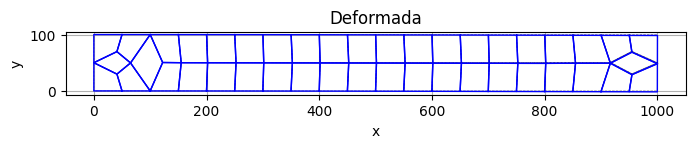

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_deformed_structure(elements, u_global, scale=1.0, show_original=True, title="Deformada"):
    """
    Grafica la estructura deformada a partir de los elementos y desplazamientos globales.
    
    Args:
        elements (list): Lista de elementos (Quad2D).
        u_global (ndarray): Vector global de desplazamientos (del solver).
        scale (float): Factor de escala para amplificar la deformación visualmente.
        show_original (bool): Si True, también grafica la geometría original.
        title (str): Título del gráfico.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_aspect('equal')
    
    for elem in elements:
        # Coordenadas originales
        xy = elem.xy
        coords = np.vstack([xy, xy[0]])  # cerrar polígono

        if show_original:
            ax.plot(coords[:, 0], coords[:, 1], 'k--', linewidth=0.5, alpha=0.5)

        # Coordenadas deformadas
        idx = elem.calculate_indices()
        u_elem = u_global[idx].flatten()

        xy_def = xy + scale * u_elem.reshape(-1, 2)
        coords_def = np.vstack([xy_def, xy_def[0]])

        ax.plot(coords_def[:, 0], coords_def[:, 1], 'b-', linewidth=1)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True)
    plt.show()


plot_deformed_structure(elements, desplazamientos, scale=10.0, show_original=True, title="Deformada")

In [12]:
from graph import plot_results
plot_results(
    estructure,
    elements,
    title="mi_estructura",
    def_scale=50,
    force_scale=1,
    reaction_scale=1e-2,
    sigma_y_tension=250, 
    sigma_y_compression=250
)

📌 Sumatoria total de reacciones: Rx = -0.000 N, Ry = 1000.000 N, ||R|| = 1000.000 N
🔧 Mínimo FS Tracción: 77.168
🔧 Mínimo FS Compresión: 76.582


In [13]:
for node in used_nodes:
    if node.coord[0] == 1000 and node.coord[1] <= 100:
        dof_y = node.dofs[1]  # Segundo DOF (desplazamiento vertical)
        uy = node.structure.u_global[dof_y, 0]
        print(f'📌 El desplazamiento vertical del nodo ({node.index}) es: {uy:.6f} mm')


📌 El desplazamiento vertical del nodo (2) es: -0.170348 mm
📌 El desplazamiento vertical del nodo (24) es: -0.170337 mm
📌 El desplazamiento vertical del nodo (3) es: -0.170348 mm
